Test the GAIA-DR2 transformation on EDR3 data

In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio

import healpy as hp

sys.path.append(os.path.expanduser('~/git/Python/user_modules/'))
from match_coord import match_coord

In [2]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
gaia_dir = '/project/projectdirs/cosmo/data/gaia/edr3/healpix'
gaia_nside = 32
gaia_npix = hp.nside2npix(gaia_nside)

In [4]:
sweep_list = ['sweep-140p015-150p020.fits', 'sweep-150p015-160p020.fits',
              'sweep-160p015-170p020.fits', 'sweep-170p015-180p020.fits', 
              'sweep-180p015-190p020.fits', 'sweep-190p015-200p020.fits',
              'sweep-140p010-150p015.fits', 'sweep-150p010-160p015.fits',
              'sweep-160p010-170p015.fits', 'sweep-170p010-180p015.fits', 
              'sweep-180p010-190p015.fits', 'sweep-190p010-200p015.fits',
              'sweep-140p005-150p010.fits', 'sweep-150p005-160p010.fits',
              'sweep-160p005-170p010.fits', 'sweep-170p005-180p010.fits', 
              'sweep-180p005-190p010.fits', 'sweep-190p005-200p010.fits']

cat_stack = []
for sweep_fn in sweep_list:
    
    cat = Table(fitsio.read('/global/project/projectdirs/cosmo/data/legacysurvey/dr9/south/sweep/9.0/'+sweep_fn,
        columns=['RA', 'DEC', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'TYPE', 'MASKBITS', 'FRACFLUX_R']))
    mask =  22.5 - 2.5*np.log10(cat['FLUX_R']) < 22.0
    # mask &= cat['TYPE']!='DUP'
    mask &= cat['TYPE']=='PSF'
    mask &= cat['FRACFLUX_R']<0.1
    cat = cat[mask]

    healpix_list = np.unique(hp.ang2pix(gaia_nside, cat['RA'], cat['DEC'], nest=True, lonlat=True))

    gaia = []
    for hp_index in healpix_list:
        gaia_fn = str(hp_index).zfill(5)
        gaia_chunk = Table(fitsio.read(os.path.join(gaia_dir, 'healpix-{}.fits'.format(gaia_fn)), columns=['SOURCE_ID', 'RA', 'DEC', 'PHOT_G_MEAN_MAG', 'PHOT_BP_MEAN_MAG', 'PHOT_RP_MEAN_MAG', 'PHOT_G_MEAN_FLUX_OVER_ERROR']))
        mask = (gaia_chunk['PHOT_G_MEAN_MAG']>16) & (gaia_chunk['PHOT_G_MEAN_MAG']<18)
        gaia_chunk = gaia_chunk[mask]
        gaia.append(gaia_chunk)
    gaia = vstack(gaia)
    idx1, idx2, d2d, d_ra, d_dec = match_coord(cat['RA'], cat['DEC'], gaia['RA'], gaia['DEC'], search_radius=0.5, plot_q=False)

    cat = cat[idx1]
    gaia = gaia[idx2]
    gaia.rename_columns(['RA', 'DEC'], ['GAIA_RA', 'GAIA_DEC'])

    cat = hstack([cat, gaia])
    cat_stack.append(cat)
    
cat_stack = vstack(cat_stack)
cat = cat_stack
print(len(cat))

<ipython-input-4-90b86796cd6b>:16: RuntimeWarning: divide by zero encountered in log10
  mask =  22.5 - 2.5*np.log10(cat['FLUX_R']) < 22.0
<ipython-input-4-90b86796cd6b>:16: RuntimeWarning: invalid value encountered in log10
  mask =  22.5 - 2.5*np.log10(cat['FLUX_R']) < 22.0


Doubly matched objects = 14
Final matched objects = 27257
Doubly matched objects = 9
Final matched objects = 22382
Doubly matched objects = 4
Final matched objects = 20247
Doubly matched objects = 5
Final matched objects = 19429
Doubly matched objects = 11
Final matched objects = 19357
Doubly matched objects = 8
Final matched objects = 21628
Doubly matched objects = 16
Final matched objects = 29820
Doubly matched objects = 10
Final matched objects = 24048
Doubly matched objects = 3
Final matched objects = 21563
Doubly matched objects = 8
Final matched objects = 20823
Doubly matched objects = 5
Final matched objects = 21185
Doubly matched objects = 12
Final matched objects = 22708
Doubly matched objects = 19
Final matched objects = 33232
Doubly matched objects = 6
Final matched objects = 26556
Doubly matched objects = 9
Final matched objects = 23698
Doubly matched objects = 9
Final matched objects = 22740
Doubly matched objects = 12
Final matched objects = 23422
Doubly matched objects =

In [5]:
cat.write('/global/cfs/cdirs/desi/users/rongpu/misc/decals_dr9_gaia_edr3.fits')

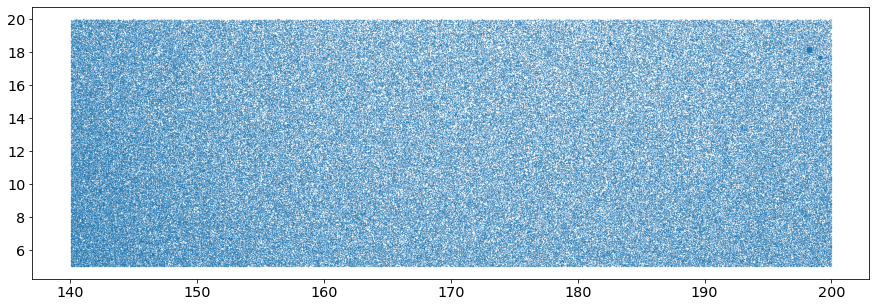

0.8732182446109467
0.8732182446109467
371426


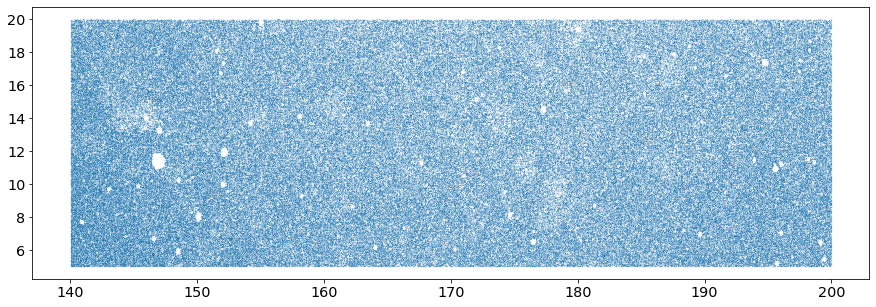

In [6]:
plt.figure(figsize=(15, 5))
plt.plot(cat['RA'], cat['DEC'], '.', ms=0.4, alpha=0.5)
plt.show()

mask = (cat['MASKBITS']==0)
print(np.sum(mask)/len(mask))
mask &= np.isfinite(cat['PHOT_BP_MEAN_MAG']) & np.isfinite(cat['PHOT_RP_MEAN_MAG'])
print(np.sum(mask)/len(mask))
print(np.sum(mask))
cat = cat[mask]

plt.figure(figsize=(15, 5))
plt.plot(cat['RA'], cat['DEC'], '.', ms=0.4, alpha=0.5)
plt.show()

In [7]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cat['gmag'] = 22.5 - 2.5*np.log10(cat['FLUX_G'])
    cat['rmag'] = 22.5 - 2.5*np.log10(cat['FLUX_R'])
    cat['zmag'] = 22.5 - 2.5*np.log10(cat['FLUX_Z'])
    
for band in ['g', 'r', 'z']:
    print(band, cat[band+'mag'].min(), cat[band+'mag'].max())

g 15.692055 22.112179
r 15.168711 19.827345
z 14.842638 18.962343


In [8]:
coeffs_new = dict(
    g = [-0.1178631039, 0.3650113495, 0.5608615360, -0.2850687702,
        -1.0243473939, 1.4378375491, 0.0679401731, -1.1713172509,
        0.9107811975, -0.3374324004, 0.0683946390, -0.0073089582,
        0.0003230170],
    r = [0.1139078673, -0.2868955307, 0.0013196434, 0.1029151074,
        0.1196710702, -0.3729031390, 0.1859874242, 0.1370162451,
        -0.1808580848, 0.0803219195, -0.0180218196, 0.0020584707,
        -0.0000953486],
    z = [0.4811198057, -0.9990015041, 0.1403990019, 0.2150988888,
        -0.2917655866, 0.1326831887, -0.0259205004, 0.0018548776])

In [10]:
gaia_plot = Table()
gaia_plot['BP_RP'] = np.linspace(-1, 6.2, 200)
bands = ['g', 'r', 'z']
for i, b in enumerate(bands):
    mag = np.zeros(len(gaia_plot))
    for order, c in enumerate(coeffs_new[b]):
        mag += c * gaia_plot['BP_RP']**order
    gaia_plot['ls_'+b] = mag
    
for i, b in enumerate(bands):
    mag = np.copy(cat['PHOT_G_MEAN_MAG'])
    for order, c in enumerate(coeffs_new[b]):
        mag += c * (cat['PHOT_BP_MEAN_MAG']-cat['PHOT_RP_MEAN_MAG'])**order
    cat[b+'mag_predict'] = mag

In [11]:
bprp_min, bprp_max = -0.6, 4.1

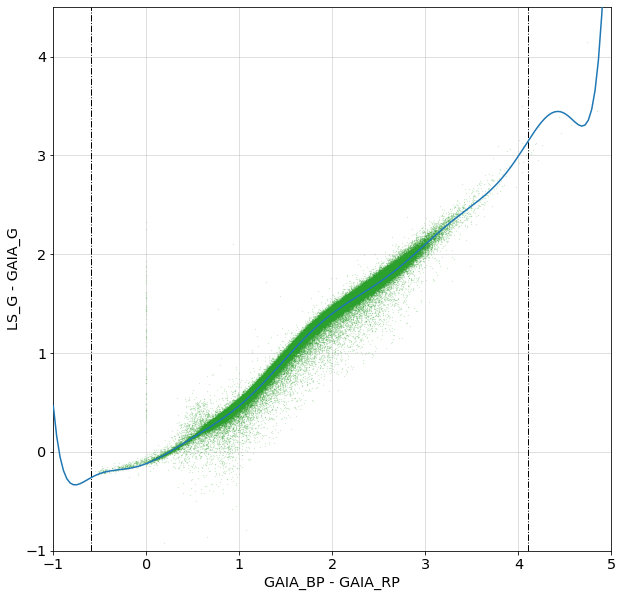

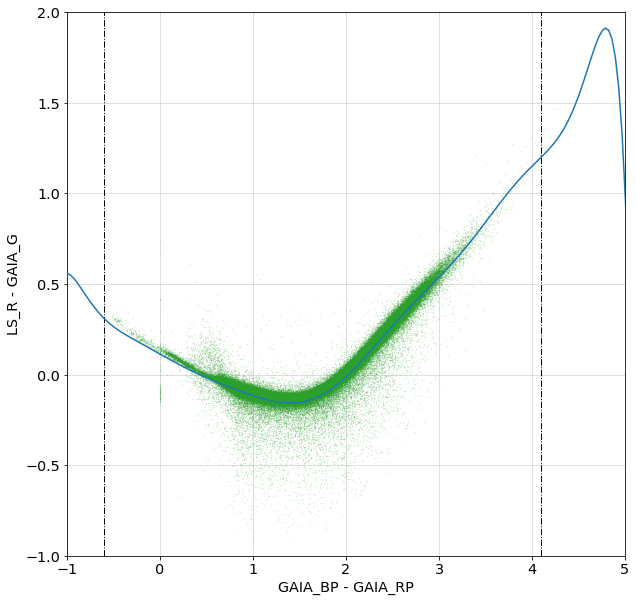

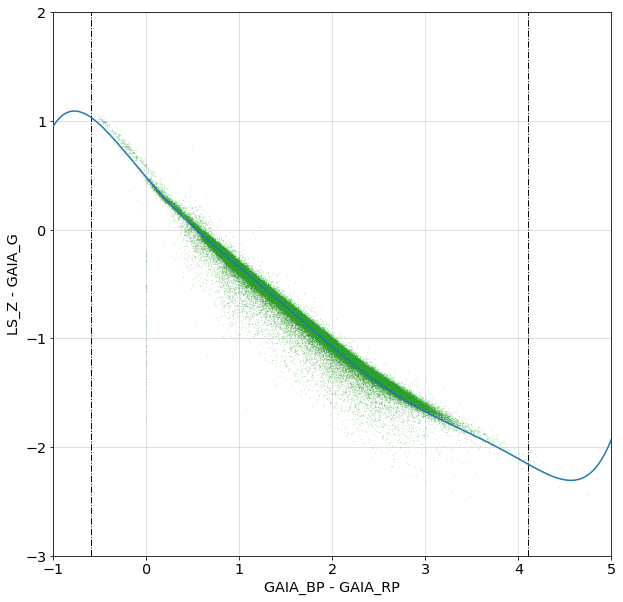

In [12]:
mask = np.ones(len(cat), dtype=bool)
# mask1 = (extreme'PHOT_BP_MEAN_MAG']-extreme'PHOT_RP_MEAN_MAG']<0) 
# mask1 |= (extreme'PHOT_BP_MEAN_MAG']-extreme'PHOT_RP_MEAN_MAG']>3.1)

plt.figure(figsize=(10, 10))
plt.plot((cat['PHOT_BP_MEAN_MAG']-cat['PHOT_RP_MEAN_MAG'])[mask], (cat['gmag']-cat['PHOT_G_MEAN_MAG'])[mask], 'C2.', ms=0.3, alpha=0.5, zorder=2, c='C2', label='_nolegend_')
# plt.plot((extreme'PHOT_BP_MEAN_MAG']-extreme'PHOT_RP_MEAN_MAG'])[mask1], (extreme['gmag']-extreme'PHOT_G_MEAN_MAG'])[mask1], '.', ms=0.5, zorder=1, c='C1', label='_nolegend_')
# plt.plot((gaia_plot_old['BP_RP']), (gaia_plot_old['ls_g']), '-', label='old transformation', zorder=3, c='C3', ls='--', lw=1)
plt.plot((gaia_plot['BP_RP']), (gaia_plot['ls_g']), '-', label='new transformation', zorder=3, c='C0')
plt.axvline(bprp_min, lw=1, ls='-.', color='k')
plt.axvline(bprp_max, lw=1, ls='-.', color='k')
plt.xlabel('GAIA_BP - GAIA_RP')
plt.ylabel('LS_G - GAIA_G')
plt.axis([-1., 5., -1, 4.5])
# plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.savefig('plots/decals_g.png')
plt.show()

plt.figure(figsize=(10, 10))
plt.plot((cat['PHOT_BP_MEAN_MAG']-cat['PHOT_RP_MEAN_MAG'])[mask], (cat['rmag']-cat['PHOT_G_MEAN_MAG'])[mask], 'C2.', ms=0.3, alpha=0.5, zorder=2, c='C2', label='_nolegend_')
# plt.plot((extreme'PHOT_BP_MEAN_MAG']-extreme'PHOT_RP_MEAN_MAG'])[mask1], (extreme['rmag']-extreme'PHOT_G_MEAN_MAG'])[mask1], '.', ms=0.5, zorder=1, c='C1', label='_nolegend_')
# plt.plot((gaia_plot_old['BP_RP']), (gaia_plot_old['ls_r']), '-', label='old transformation', zorder=3, c='C3', ls='--', lw=1)
plt.plot((gaia_plot['BP_RP']), (gaia_plot['ls_r']), '-', label='new transformation', zorder=3, c='C0')
plt.axvline(bprp_min, lw=1, ls='-.', color='k')
plt.axvline(bprp_max, lw=1, ls='-.', color='k')
plt.xlabel('GAIA_BP - GAIA_RP')
plt.ylabel('LS_R - GAIA_G')
plt.axis([-1., 5., -1, 2])
# plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.savefig('plots/decals_r.png')
plt.show()

plt.figure(figsize=(10, 10))
plt.plot((cat['PHOT_BP_MEAN_MAG']-cat['PHOT_RP_MEAN_MAG'])[mask], (cat['zmag']-cat['PHOT_G_MEAN_MAG'])[mask], 'C2.', ms=0.3, alpha=0.5, zorder=2, c='C2', label='_nolegend_')
# plt.plot((extreme'PHOT_BP_MEAN_MAG']-extreme'PHOT_RP_MEAN_MAG'])[mask1], (extreme['zmag']-extreme'PHOT_G_MEAN_MAG'])[mask1], '.', ms=0.5, zorder=1, c='C1', label='_nolegend_')
# plt.plot((gaia_plot_old['BP_RP']), (gaia_plot_old['ls_z']), '-', label='old transformation', zorder=3, c='C3', ls='--', lw=1)
plt.plot((gaia_plot['BP_RP']), (gaia_plot['ls_z']), '-', label='new transformation', zorder=3, c='C0')
plt.axvline(bprp_min, lw=1, ls='-.', color='k')
plt.axvline(bprp_max, lw=1, ls='-.', color='k')
plt.xlabel('GAIA_BP - GAIA_RP')
plt.ylabel('LS_Z - GAIA_G')
plt.axis([-1., 5., -3, 2.])
# plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.savefig('plots/decals_z.png')
plt.show()

In [13]:
from scipy import stats

nmad = lambda x: 1.4826*np.median(np.abs(x-np.median(x)))
error_of_the_mean = lambda x: nmad(x)/np.sqrt(len(x))

def binned_median(x, y, nbins=50):
    vmin, vmax = np.percentile(x, [0.1, 99.9])
    bins = np.linspace(vmin, vmax, nbins)
    bin_median, bin_edges, binnumber = stats.binned_statistic(x, y, statistic='median', bins=bins)
    bin_error, _, _ = stats.binned_statistic(x, y, statistic=error_of_the_mean, bins=bins)    
    bin_center = (bin_edges[1:] + bin_edges[:-1])/2
    return bin_center, bin_edges, bin_median, bin_error

def binned_std(x, y, nbins=50):
    vmin, vmax = np.percentile(x, [0.1, 99.9])
    bins = np.linspace(vmin, vmax, nbins)
    bin_std, bin_edges, binnumber = stats.binned_statistic(x, y, statistic='std', bins=bins)
    bin_center = (bin_edges[1:] + bin_edges[:-1])/2
    return bin_center, bin_edges, bin_std

def binned_nmad(x, y, nbins=50):
    nmad = lambda x: 1.4826*np.median(np.abs(x-np.median(x)))
    vmin, vmax = np.percentile(x, [0.1, 99.9])
    bins = np.linspace(vmin, vmax, nbins)
    bin_nmad, bin_edges, binnumber = stats.binned_statistic(x, y, statistic=nmad, bins=bins)
    bin_center = (bin_edges[1:] + bin_edges[:-1])/2
    return bin_center, bin_edges, bin_nmad

RMS 1496425900.0
NMAD 0.020547049713134764


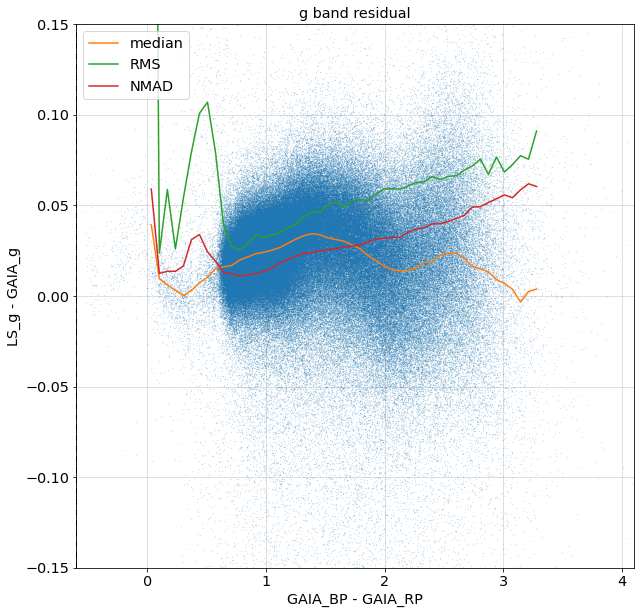

RMS 416993470.0
NMAD 0.012948656845092773


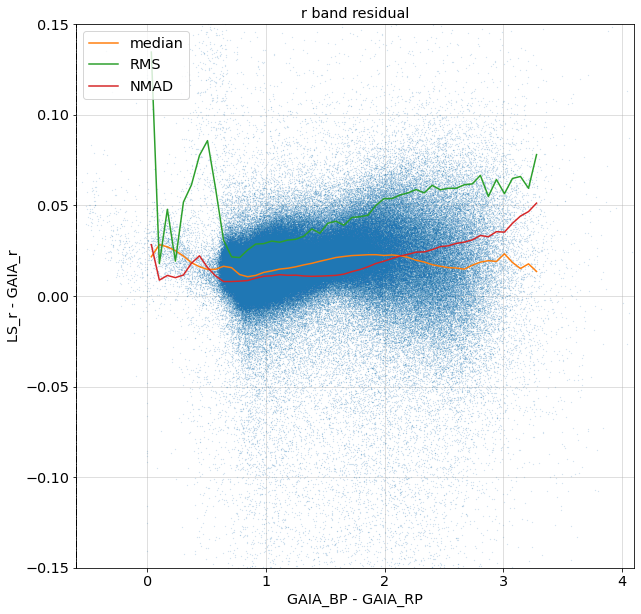

RMS 3869.7058
NMAD 0.020770448684692383


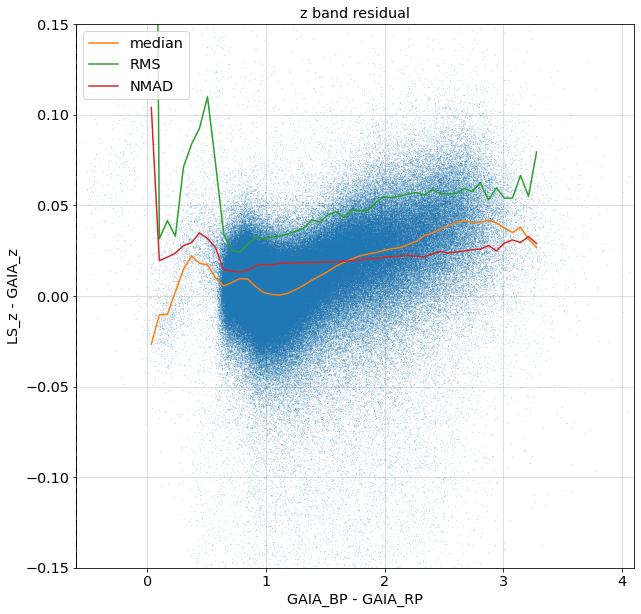

In [14]:
for band in ['g', 'r', 'z']:
    x = cat['PHOT_BP_MEAN_MAG']-cat['PHOT_RP_MEAN_MAG']
    y_tractor = cat[band+'mag']
    y_predict = cat[band+'mag_predict']

    print('RMS', np.std(y_tractor-y_predict))    
    print('NMAD', nmad(y_tractor-y_predict))
    
    bin_center, bin_edges, bin_median, bin_error = binned_median(x, y_tractor-y_predict)
    bin_center, bin_edges, bin_std = binned_std(x, y_tractor-y_predict)
    bin_center, bin_edges, bin_nmad = binned_nmad(x, y_tractor-y_predict)
    
    plt.figure(figsize=(10, 10))
    plt.plot(x, y_tractor-y_predict, '.', ms=0.3, alpha=0.5, zorder=2)
    plt.plot(bin_center, bin_median, label='median')
    plt.plot(bin_center, bin_std, label='RMS')
    plt.plot(bin_center, bin_nmad, label='NMAD')
    plt.axvline(bprp_min, lw=1, ls='-.', color='k')
    plt.axvline(bprp_max, lw=1, ls='-.', color='k')
    plt.xlabel('GAIA_BP - GAIA_RP')
    plt.ylabel('LS_{0} - GAIA_{0}'.format(band))
    plt.title('{} band residual'.format(band))
    plt.axis([bprp_min, bprp_max, -0.15, 0.15])
    plt.grid(alpha=0.5)
    plt.legend(markerscale=10, loc='upper left')
    plt.savefig('plots/decals_{}_residual.png'.format(band))
    plt.show()